### Solving `MountainCarContinuous-v0` Problem using SAC (Soft Actor-Critic)
> Mahdi Shahrajabian, Jan 2025

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam
import gym
# import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("Keras %s" % keras.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.10.0
tfp 0.18.0
Keras 2.10.0
gym 0.26.0
numpy 1.23.0


## SAC algorithm

<center>
<img src="sac_dong.png" alt="SAC" width=500/>
</center>


In [2]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.m_size = max_size
        self.m_cntr = 0
        self.state_m = np.zeros((self.m_size, *input_shape))
        self.new_state_m = np.zeros((self.m_size, *input_shape))
        self.action_m = np.zeros((self.m_size, n_actions))
        self.reward_m = np.zeros(self.m_size)
        self.terminal_m = np.zeros(self.m_size)

    def store(self, state, action, reward, state_, done):
        id = self.m_cntr % self.m_size

        self.state_m[id] = state
        self.new_state_m[id] = state_
        self.action_m[id] = action
        self.reward_m[id] = reward
        self.terminal_m[id] = done

        self.m_cntr += 1

    def sample(self, batch_size):
        max_m = min(self.m_cntr, self.m_size)

        batch = np.random.choice(max_m, batch_size)

        states = self.state_m[batch]
        states_ = self.new_state_m[batch]
        actions = self.action_m[batch]
        rewards = self.reward_m[batch]
        dones = self.terminal_m[batch]

        return states, actions, rewards, states_, dones

In [3]:
class CriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256, name='critic'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

In [4]:
class ValueNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256, name='value'):
        super(ValueNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.v = Dense(1, activation=None)

    def call(self, state):
        state_value = self.fc1(state)
        state_value = self.fc2(state_value)

        v = self.v(state_value)

        return v

In [5]:
class ActorNetwork(keras.Model):
    def __init__(self, max_action, fc1_dims=256, 
            fc2_dims=256, n_actions=2, name='actor'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.max_action = max_action
        self.noise = 1e-6

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation=None)
        self.sigma = Dense(self.n_actions, activation=None)

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)
        sigma = tf.clip_by_value(sigma, self.noise, 1)
        
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.call(state)

        if reparameterize:
            # During training: Reparameterization trick
            # sample epsilon from standard normal, and then transform it using mu and sigma
            epsilon = tf.random.normal(shape=mu.shape)
            actions = mu + epsilon * sigma
        else:
            # During action selection, directly sample from the normal distribution
            probabilities = tfp.distributions.Normal(mu, sigma)
            actions = probabilities.sample()

        # Apply tanh squashing
        action = tf.math.tanh(actions)

        # Calculate log probabilities (using the original normal distribution)
        probabilities = tfp.distributions.Normal(mu, sigma)
        log_probs = probabilities.log_prob(actions)

        # Apply the squashing correction
        log_probs -= tf.math.log(1 - tf.math.pow(action, 2) + self.noise)
        log_probs = tf.math.reduce_sum(log_probs, axis=1, keepdims=True)

        return action, log_probs

In [6]:
class Agent:
    def __init__(self, alpha=0.0003, beta=0.0003, input_dims=[8],
            env=None, gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
            layer1_size=128, layer2_size=128, batch_size=128, reward_scale=2):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions

        # Initialize temperature parameter (alpha) and its optimizer
        self.log_alpha = tf.Variable(tf.math.log(0.2), dtype=tf.float32)
        self.alpha_T = tf.exp(self.log_alpha)
        self.alpha_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

        # Optional: Set target entropy (can also be set in learn method)
        self.target_entropy = -tf.cast(self.n_actions, dtype=tf.float32)

        self.actor = ActorNetwork(n_actions=n_actions, name='actor', 
                                    max_action=env.action_space.high)
        self.critic_1 = CriticNetwork(n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(n_actions=n_actions, name='critic_2')
        self.value = ValueNetwork(name='value')
        self.target_value = ValueNetwork(name='target_value')

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic_1.compile(optimizer=Adam(learning_rate=beta))
        self.critic_2.compile(optimizer=Adam(learning_rate=beta))
        self.value.compile(optimizer=Adam(learning_rate=beta))
        self.target_value.compile(optimizer=Adam(learning_rate=beta))

        self.scale = reward_scale
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_value.weights
        for i, weight in enumerate(self.value.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_value.set_weights(weights)

    def learn(self):
        if self.memory.m_cntr < self.batch_size:
            return 0, 0, 0, 0

        state, action, reward, new_state, done = \
                self.memory.sample(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        # Update temperature parameter

        # target_entropy = -tf.cast(tf.shape(action)[-1], dtype=tf.float32)
        # with tf.GradientTape() as tape:
        #     _, log_probs = self.actor.sample_normal(states, reparameterize=True)
        #     log_probs = tf.squeeze(log_probs, 1)
        #     alpha_loss = -tf.reduce_mean(
        #         self.log_alpha * tf.stop_gradient(log_probs + target_entropy))
        #
        # alpha_gradient = tape.gradient(alpha_loss, [self.log_alpha])
        # self.alpha_optimizer.apply_gradients(zip(alpha_gradient, [self.log_alpha]))
        # self.alpha_T = tf.exp(self.log_alpha)

        with tf.GradientTape() as tape:
            value = tf.squeeze(self.value(states), 1)
            value_ = tf.squeeze(self.target_value(states_), 1)

            current_policy_actions, log_probs = self.actor.sample_normal(states,
                                                        reparameterize=False)
            log_probs = tf.squeeze(log_probs,1)
            q1_new_policy = self.critic_1(states, current_policy_actions)
            q2_new_policy = self.critic_2(states, current_policy_actions)
            critic_value = tf.squeeze(
                                tf.math.minimum(q1_new_policy, q2_new_policy), 1)

            value_target = critic_value - self.alpha_T * log_probs
            value_loss = 0.5 * keras.losses.MSE(value, value_target)

        value_network_gradient = tape.gradient(value_loss, 
                                                self.value.trainable_variables)
        self.value.optimizer.apply_gradients(zip(
                       value_network_gradient, self.value.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions, log_probs = self.actor.sample_normal(states,
                                                reparameterize=True)
            log_probs = tf.squeeze(log_probs, 1)
            q1_new_policy = self.critic_1(states, new_policy_actions)
            q2_new_policy = self.critic_2(states, new_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(
                                        q1_new_policy, q2_new_policy), 1)
        
            actor_loss = self.alpha_T * log_probs - critic_value
            actor_loss = tf.math.reduce_mean(actor_loss)
            log_probs_2 = log_probs

        actor_network_gradient = tape.gradient(actor_loss, 
                                            self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
                        actor_network_gradient, self.actor.trainable_variables))
        

        with tf.GradientTape(persistent=True) as tape:
            q_hat = self.scale*reward + self.gamma*value_*(1-done)
            q1_old_policy = tf.squeeze(self.critic_1(state, action), 1)
            q2_old_policy = tf.squeeze(self.critic_2(state, action), 1)
            critic_1_loss = 0.5 * keras.losses.MSE(q1_old_policy, q_hat)
            critic_2_loss = 0.5 * keras.losses.MSE(q2_old_policy, q_hat)
    
        critic_1_network_gradient = tape.gradient(critic_1_loss,
                                        self.critic_1.trainable_variables)
        critic_2_network_gradient = tape.gradient(critic_2_loss,
            self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(zip(
            critic_1_network_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(
            critic_2_network_gradient, self.critic_2.trainable_variables))

        self.update_network_parameters()

        return value_loss, actor_loss, critic_1_loss, critic_2_loss

## Main

In [ ]:
%%time

env = gym.make('MountainCarContinuous-v0')
agent = Agent(input_dims=env.observation_space.shape, env=env,
              n_actions=env.action_space.shape[0])
n_episodes = 150
n_steps = 1000

score_history = []
value_losses = []
actor_losses = []
critic_1_losses = []
critic_2_losses = []
goal_count = 0
successful_rates = []
successful_steps = []
avg_s_steps = []


for i in range(n_episodes):
    observation, _ = env.reset()
    done = False
    score = 0
    steps = 0
    best_positive_pos_episode = observation[0]
    for t in range(n_steps):
        steps += 1
        action = agent.choose_action(observation)

        observation_, reward, done, _, _ = env.step(action.numpy())  
        score += reward
        if observation_[0]>best_positive_pos_episode:
            best_positive_pos_episode = observation_[0]
            reward += 1
        reward+=abs(observation_[1])
        
        agent.remember(observation, action, reward, observation_, done)
        value_loss, actor_loss, critic_1_loss, critic_2_loss = agent.learn()
        observation = observation_
        if done:
            goal_count += 1
            successful_steps.append(t)
            break
    score_history.append(score)

    value_losses.append(value_loss)
    actor_losses.append(actor_loss)
    critic_1_losses.append(critic_1_loss)
    critic_2_losses.append(critic_2_loss)

    avg_score = np.mean(score_history[-100:])
    avg_successful_steps = np.mean(successful_steps) if successful_steps else float('inf')
    avg_s_steps.append(avg_successful_steps)
    successful_rates.append(goal_count)
    if (i+1) % 2 == 0:
        print(f"Episode: {i+1:4d} | "
              f"Score: {int(score):4d} | "
              f"Avg Score: {int(avg_score):4d} | "
              f"Goal Count:{goal_count:3d} | "
              f"Avg Steps to Goal: {avg_successful_steps:.2f} | "
              f"Actor Loss: {actor_loss:.2f} | "
              f"Critic 1 Loss: {critic_1_loss:.2f} | "
              f"Critic 2 Loss: {critic_2_loss:.2f} | "
              f"Value Loss: {value_loss:.2f}")


C:\Users\Mahdi\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:    2 | Score:  -66 | Avg Score:  -43 | Goal Count:  0 | Avg Steps to Goal: inf | Actor Loss: -0.63 | Critic 1 Loss: 0.09 | Critic 2 Loss: 0.09 | Value Loss: 0.01
Episode:    4 | Score:  -61 | Avg Score:  -49 | Goal Count:  0 | Avg Steps to Goal: inf | Actor Loss: -1.59 | Critic 1 Loss: 0.09 | Critic 2 Loss: 0.10 | Value Loss: 0.02
Episode:    6 | Score:   56 | Avg Score:  -32 | Goal Count:  1 | Avg Steps to Goal: 699.00 | Actor Loss: -2.55 | Critic 1 Loss: 0.14 | Critic 2 Loss: 0.14 | Value Loss: 0.01
Episode:    8 | Score:   30 | Avg Score:  -12 | Goal Count:  3 | Avg Steps to Goal: 512.67 | Actor Loss: -5.24 | Critic 1 Loss: 0.25 | Critic 2 Loss: 0.24 | Value Loss: 0.05
Episode:   10 | Score:   68 | Avg Score:    1 | Goal Count:  5 | Avg Steps to Goal: 470.80 | Actor Loss: -5.53 | Critic 1 Loss: 56.80 | Critic 2 Loss: 56.54 | Value Loss: 0.10
Episode:   12 | Score:   80 | Avg Score:   14 | Goal Count:  7 | Avg Steps to Goal: 409.71 | Actor Loss: -7.09 | Critic 1 Loss: 0.21 |

# Results
## Learning curves

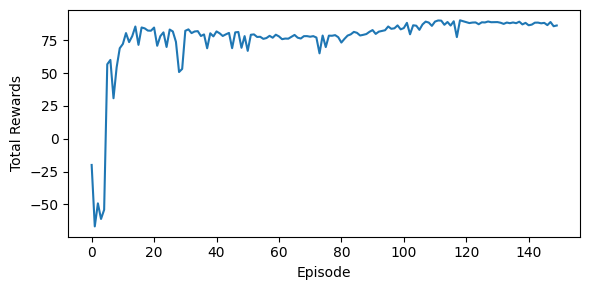

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(score_history)
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.tight_layout()
#plt.savefig("MC_SAC_r.pdf", bbox_inches='tight') 
plt.show()

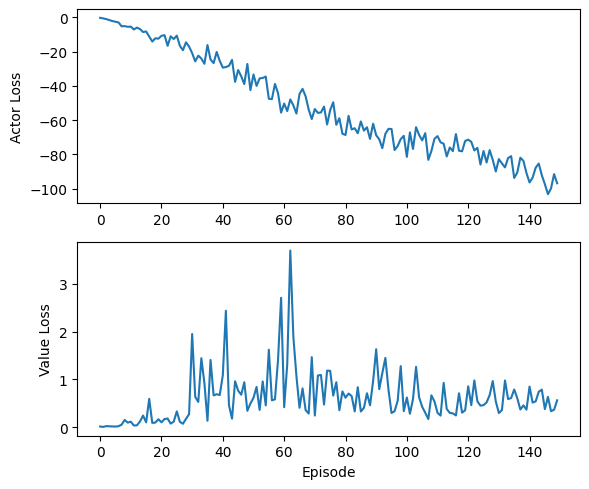

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(actor_losses)
# plt.xlabel('Episode')
plt.ylabel('Actor Loss')
plt.subplot(2, 1, 2)
plt.plot(value_losses)
plt.xlabel('Episode')
plt.ylabel('Value Loss')
plt.tight_layout()
#plt.savefig("MC_SAC_AVloss.pdf", bbox_inches='tight') 
plt.show()

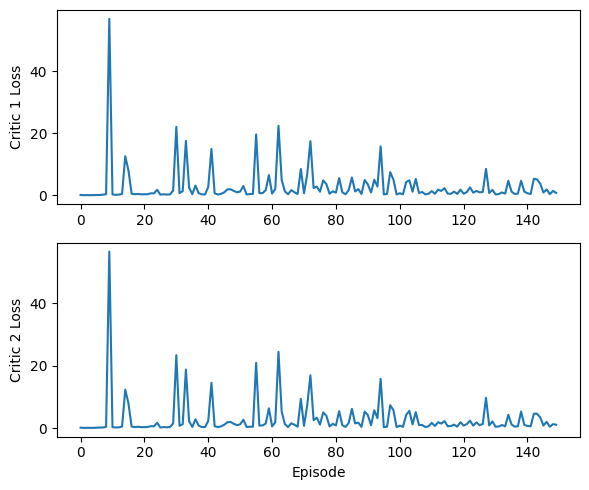

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(critic_1_losses)
# plt.xlabel('Episode')
plt.ylabel('Critic 1 Loss')
plt.subplot(2, 1, 2)
plt.plot(critic_2_losses)
plt.xlabel('Episode')
plt.ylabel('Critic 2 Loss')
plt.tight_layout()
#plt.savefig("MC_SAC_Closs.pdf", bbox_inches='tight') 
plt.show()

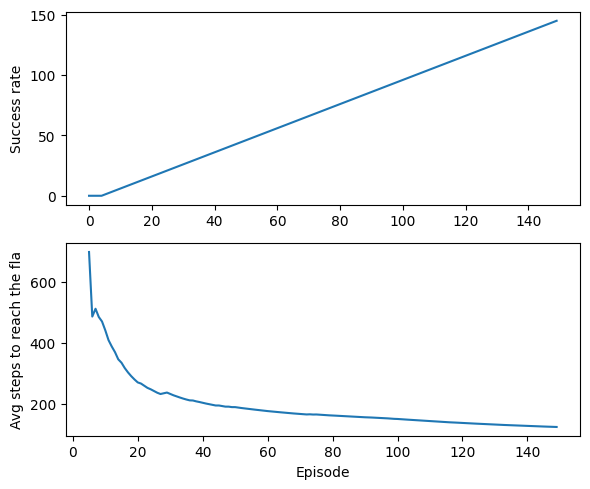

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(successful_rates)
# plt.xlabel('Episode')
plt.ylabel('Success rate')
plt.subplot(2, 1, 2)
plt.plot(avg_s_steps)
plt.xlabel('Episode')
plt.ylabel('Avg steps to reach the fla')
plt.tight_layout()
#plt.savefig("MC_SAC_Succ.pdf", bbox_inches='tight') 
plt.show()



## Cost-to-go

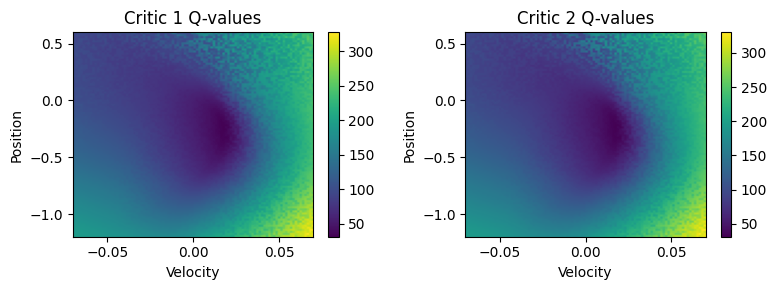

In [ ]:
def plot_heatmap(agent, env, resolution=100):
    # Create a grid of positions and velocities
    position = np.linspace(env.observation_space.low[0], env.observation_space.high[0], resolution)
    velocity = np.linspace(env.observation_space.low[1], env.observation_space.high[1], resolution)
    
    # Initialize heatmaps
    critic1_values = np.zeros((resolution, resolution))
    critic2_values = np.zeros((resolution, resolution))

    for i, pos in enumerate(position):
        for j, vel in enumerate(velocity):
            state = np.array([[pos, vel]], dtype=np.float32)  # State as a 2D tensor
            action = np.array([env.action_space.sample()], dtype=np.float32)  # Create 1D array
            action = action.reshape(1, -1)  # Reshape to match state tensor shape


            # Compute Q-values for Critic 1 and Critic 2
            q1 = agent.critic_1(tf.convert_to_tensor(state), tf.convert_to_tensor(action))
            q2 = agent.critic_2(tf.convert_to_tensor(state), tf.convert_to_tensor(action))

            critic1_values[i, j] = q1.numpy()[0][0]
            critic2_values[i, j] = q2.numpy()[0][0]

    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    c1 = axes[0].imshow(critic1_values, extent=[env.observation_space.low[1], env.observation_space.high[1],
                                                 env.observation_space.low[0], env.observation_space.high[0]], 
                       origin='lower', aspect='auto', cmap='viridis')
    axes[0].set_title("Critic 1 Q-values")
    axes[0].set_xlabel("Velocity")
    axes[0].set_ylabel("Position")
    fig.colorbar(c1, ax=axes[0])

    c2 = axes[1].imshow(critic2_values, extent=[env.observation_space.low[1], env.observation_space.high[1],
                                                 env.observation_space.low[0], env.observation_space.high[0]], 
                       origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title("Critic 2 Q-values")
    axes[1].set_xlabel("Velocity")
    axes[1].set_ylabel("Position")
    fig.colorbar(c2, ax=axes[1])

    plt.tight_layout()
    #plt.savefig("MC_SAC_cheat.pdf", bbox_inches='tight') 
    plt.show()

plot_heatmap(agent, env)


## Policy map

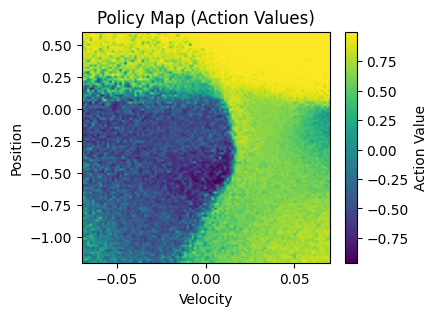

In [ ]:
def plot_policy_map(agent, env, resolution=100):
    # Create a grid of positions and velocities
    position = np.linspace(env.observation_space.low[0], env.observation_space.high[0], resolution)
    velocity = np.linspace(env.observation_space.low[1], env.observation_space.high[1], resolution)
    
    # Initialize policy map
    policy_map = np.zeros((resolution, resolution))

    for i, pos in enumerate(position):
        for j, vel in enumerate(velocity):
            state = np.array([[pos, vel]], dtype=np.float32)  # State as a 2D tensor
            action, _ = agent.actor.sample_normal(tf.convert_to_tensor(state), reparameterize=False)
            policy_map[i, j] = action.numpy()[0][0]  # Assuming 1D action space

    # Plot policy map
    plt.figure(figsize=(4, 3))
    plt.imshow(policy_map, extent=[env.observation_space.low[1], env.observation_space.high[1],
                                   env.observation_space.low[0], env.observation_space.high[0]], 
               origin='lower', aspect='auto', cmap='viridis')
    plt.title("Policy Map (Action Values)")
    plt.xlabel("Velocity")
    plt.ylabel("Position")
    plt.colorbar(label="Action Value")
    #plt.savefig("MC_SAC_pheat.pdf", bbox_inches='tight') 
    plt.show()
plot_policy_map(agent, env)

## State histogram

In [35]:
     
def Simulation(env, agent, num_episodes: int = 5) -> tuple:  
    state_rec = []

    for i in range(num_episodes):
        state, _ = env.reset()
        
        for i in range(500):
            state_rec.append(state)
            action = agent.choose_action(state)
            next_state,r,terminated,_,_ = env.step(action)
            state = next_state
            if terminated:
                break
   
    return state_rec
    
state_rec = Simulation(env, agent) 

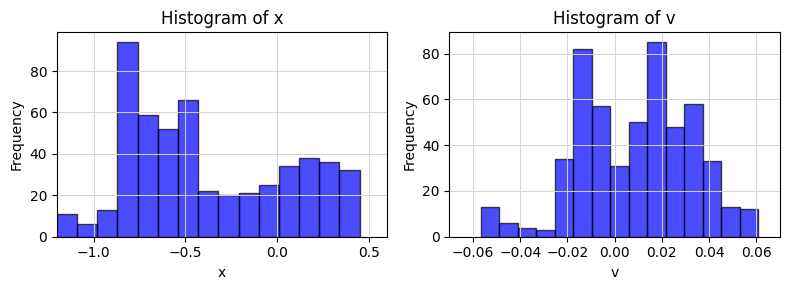

In [ ]:
variable_names = [r'x', r'v']  
all_states = np.vstack(state_rec) 
x_lim = [np.array([-1.2,0.6]), np.array([-0.07,0.07])]
plt.figure(figsize=(8, 3))
for i in range(2):
    plt.subplot(1, 2, i + 1)  
    plt.hist(all_states[:,i],bins=15,  alpha=0.7,color='blue',edgecolor='black')
    plt.title(f'Histogram of {variable_names[i]}')
    plt.xlabel(variable_names[i])
    plt.xlim(x_lim[i])
    plt.ylabel('Frequency')
    plt.gca().set_facecolor('white')
    plt.grid(color='lightgray', linestyle='-', linewidth=0.7)

plt.tight_layout()  
#plt.savefig("MC_SAC_histogram.pdf", bbox_inches='tight') 
plt.show()

## Render the learned policy

In [ ]:
from IPython.display import Video, display
import cv2

def render_MC(agent):
    num_timesteps = 1000
    env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "MC_SAC_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        action = agent.choose_action(state)
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        out.write(frame_bgr)
        if done: 
            break
    out.release()
    env.close()
    display(Video(video_path))

render_MC(agent)